[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/HSinger04/VOGUE-Reimplementation/blob/main/cryu854/Image2Latent.ipynb)

# Prerequisites

A Google Drive account is needed for this notebook to be run. In the cell under "Mount drive for dataset and weights", please state under ```PRT_DIRS``` as key your identifier (e.g. "hermann") and as value a directory dedicated to this notebook (e.g. "Latent2Images"). Then, set ```PRT_DIR = PRT_DIRS[<your_identifier>]```  Then, go to 
https://drive.google.com/drive/folders/1u2xu7bSrWxrbUxk-dT-UvEJq8IjdmNTP, right-click on "ffhq-dataset" at "Shared with me > ffhq-dataset" and click on "Add a shortcut to Drive". Create the shortcut the directory dedicated to this notebook. Please go to https://drive.google.com/drive/folders/1BO98vdtQSUjRKqlIIoiRVtBM_mCEcoFc and do the same as you did with "ffhq-dataset" with "official_1024x1024" at "Shared with me > StyleGAN2models > weights-ffhq > official_1024x1024". 

This is needed, as "ffhq-dataset" points to the training dataset which is too large to download / upload oneself, "official_1024x1024" contains weights for the StyleGAN2 generator used in this notebook and also, tensorboard logs and training variables (e.g. encoder weights) get saved in the folder dedicated to this notebook.

When you run the cell under "Mount drive for dataset and weights", you will need to MANUALLY authenticate access to Google Drive.


## Mount drive for dataset and weights

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

PRT_DIRS = {"hermann": "/content/drive/MyDrive/Lernen/Coxi/IANNwTF/",
            "hermann2": "/content/drive/MyDrive/Latent2Images/"}
# parent directory of "ffhq-dataset", "official_1024x1024", "logs"
PRT_DIR = PRT_DIRS["hermann2"]

Mounted at /content/drive


In [2]:
%cd /content
!git clone https://github.com/HSinger04/VOGUE-Reimplementation

/content
Cloning into 'VOGUE-Reimplementation'...
remote: Enumerating objects: 226, done.
remote: Counting objects: 100% (226/226), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 529 (delta 148), reused 0 (delta 0), pack-reused 303
Receiving objects: 100% (529/529), 84.58 MiB | 26.02 MiB/s, done.
Resolving deltas: 100% (314/314), done.


In [3]:
%cd /content/VOGUE-Reimplementation/cryu854/

/content/VOGUE-Reimplementation/cryu854


## Imports

In [4]:
import os
import numpy as np

import tensorflow as tf
from tensorflow.keras.layers import \
BatchNormalization, ELU, Conv2D, Input, Layer, Concatenate, \
GlobalAveragePooling2D, Dropout
from tensorflow.keras import Model

## Debug control

In [5]:
# Set to True if you want to deactivate tf.function for debugging, else leave at False
tf.config.run_functions_eagerly(False)

## Load data

In [6]:
# Pro: Save space in google drive
# Contra: Needs to load the whole dataset every time
# use list_files to get generate dataset from data in different subdirectories easily
data = tf.data.Dataset.list_files(PRT_DIR + "ffhq-dataset/images1024x1024/" 
                                  + "[0-9]" * 2
                                  + "000/*.png")

## Data pipeline

In [7]:
# Data pipeline constants
# shuffle_size shouldn't be much higher than 100. Otherwise, Google Colab runs out of memory
shuffle_size = 100
BATCH_SIZE = 2
PREFETCH_SIZE = tf.data.experimental.AUTOTUNE

In [8]:
def decode_ffhq(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    return img

# Convert paths to image
data = data.map(decode_ffhq)

In [9]:
# TODO: Show some images

In [10]:
# Normalize to [-1, 1] to match StyleGAN2's generator's output
data = data.map(lambda x: (tf.cast(x, tf.float32) / 127.5) - 1)
# Shuffle whole dataset once
#data = data.shuffle(buffer_size=shuffle_size)
data = data.batch(BATCH_SIZE)
# Shuffle batch each iteration 
# TODO: left out for now due to memory issues
#data = data.shuffle(buffer_size=shuffle_size, reshuffle_each_iteration=True)
#data = data.prefetch(PREFETCH_SIZE)

# Loading trained StyleGAN2 Generator

## Actually load the model

In [11]:
!git pull
import tensorflow as tf
from modules.generator import generator

resolution = 1024  
config = "f"
num_labels = 0
checkpoint_path = PRT_DIR + "official_1024x1024/"

Gs = generator(resolution, num_labels, config, randomize_noise=False)
ckpt = tf.train.Checkpoint(generator_clone=Gs)
print(f'Loading network from {checkpoint_path}...')
ckpt.restore(tf.train.latest_checkpoint(checkpoint_path)).expect_partial()
# Freeze Generator since we don't want to train it
Gs.trainable = False

Already up to date.
Loading network from /content/drive/MyDrive/Latent2Images/official_1024x1024/...


## Generate and show images

In [12]:
# returns image in the correct range of 0 to 225
@tf.function
def get_img(x, truncation_psi, training=False):
    # TODO: change comment below better
    # Generator returns values that should be clipped to -1 and 1
    img = Gs(x, truncation_psi=truncation_psi, training=training)
    img = tf.clip_by_value(img, clip_value_min=-1.0, clip_value_max=1.0)
    return img

In [13]:
truncation_psi = 0.5
latent_size = 512
latents = tf.random.normal([BATCH_SIZE, latent_size])
# TODO: from _get_labels
labels_indice = [0]*BATCH_SIZE
labels = tf.zeros([BATCH_SIZE, 0], tf.float32)
# Generate images
images = get_img([latents, labels], truncation_psi)

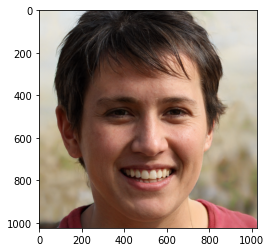

In [14]:
from matplotlib import pyplot as plt

# TODO: proper image displaying
for i in range(BATCH_SIZE):
    temp = images[i]
    temp = (temp + 1) * 127.5
    plt.imshow(temp.numpy().astype(np.uint8))
    break

## Code by HW6

In [15]:
class TransitionLayers(Layer):
  
  def __init__(self, num_filters):
    """Initialize a Transition Layer consisting of two Convolutional Layers (one acts as a Bottleneck, the other as Pooling Layer). 
    These Layers can be placed between the Dense Blocks in our DenseNet.

    Arguments:
      num_filters (list): Number of filters, one for each conv layer in our Transition Layer.
    """  

    # use the keyword super to allow our network to access the init() form the keras Layer class
    super(TransitionLayers, self).__init__()

    # extract filters
    self.filter1, self.filter2 = num_filters

    # define set of layers
    self.TransitionLayer = [
        BatchNormalization(),
        ELU(),                           
        Conv2D(filters=self.filter1, kernel_size=1, strides=1, padding="valid",  activation=None),
        BatchNormalization(),
        ELU(),
        Conv2D(filters=self.filter2, kernel_size=2, strides=2, padding="valid",  activation=None),
        Dropout(0.5)]

  @tf.function 
  def call(self, x, training=True):
    """Activate our Transition Layers by propagating the input through them

    Arguments:
      x (Tensor): Tensor containing the input to our Transition Layers
      training (Boolean): Indicates whether regularization methods should be used or not when calling the Transition Layer

    Returns:
      x (Tensor): Tensor containing the drive of the Transition Layers
    """
    for layer in self.TransitionLayer:
      x = layer(x, training = training)
    return x

In [16]:
class Block(Layer):

  def __init__(self, filter, growth_rate):
    """Initialize a Block with two Convolutional Layers (the first one acts a Bottleneck, the other is a normal 3x3 Convolutional Layer). 
    At the end of each Block, the input is concatenated to the Blocks output. Groups of Blocks are connected by Transition Layers.

    Arguments:
      filter (int): Defines number of filters for the Bottleneck Layer
      growth_rate (int): Defines the number of added channels per concatenation
    """  

    # use the keyword super to allow our network to access the init() from the keras Layer class
    super(Block, self).__init__()

    self.BlockLayers = [
        BatchNormalization(),
        ELU(),
        Conv2D(filters=filter, kernel_size=1, padding="valid",  activation=None),
        BatchNormalization(),
        ELU(),
        Conv2D(filters=growth_rate, kernel_size=3, padding="same",  activation=None)]

    # We use this layer to concatenate the input of a Block to its output
    self.concatenate = Concatenate()

  @tf.function 
  def call(self, x, training=True):
    """Activate one Block by propagating the input through the Block layer by layer

    Arguments:
      x (Tensor): Tensor containing the input to our Block
      training (Boolean): Indicates whether regularization methods should be used or not when calling the Block 

    Returns:
      x (Tensor): Tensor containing the concatenated feature maps
    """
    y = x

    for layer in self.BlockLayers:
      y = layer(y, training = training)

    # concatenate input to output
    y = self.concatenate([y,x])
    return y

In [17]:
class DenseBlock(Layer):

  def __init__(self, filter, growth_rate, num_blocks):
    """Initialize a DenseBlock consiting of several Blocks

    Arguments:
      filter (int): Defines number of filters for the Bottleneck Layer
      growth_rate (int): Defines the number of added channels per concatenation
      num_blocks (int): Number of consecutive Blocks
    """  

    # use the keyword super to allow our network to access the init() from the keras Layer class
    super(DenseBlock, self).__init__()

    self.DenseBlockLayers = [Block(filter, growth_rate) for _ in range(num_blocks)]


  @tf.function 
  def call(self, x, training=True):
    """Activate one DenseBlock by propagating the input through the DenseBlock layer by layer

    Arguments:
      x (Tensor): Tensor containing the input to our DenseBlock
      training (Boolean): Indicates whether regularization methods should be used or not when calling the DenseBlock 

    Returns:
      x (Tensor): Outputs the feature maps of a whole DenseBlock
    """

    for block in self.DenseBlockLayers:
      x = block(x, training = training)

    return x

In [18]:
class DenseNetwork(Model):

  def __init__(self):
    """Initialize a DenseNet with a variable amount of keras.Layers
    """  
    # use the keyword super to allow our network to access the init() form the keras Model class
    super(DenseNetwork, self).__init__()

    self.DenseNetLayers = [Conv2D(filters=16, kernel_size=3, padding="same",  activation=None)]

    self.DenseNetLayers.append(DenseBlock(filter=16, growth_rate=12, num_blocks=2))

    self.DenseNetLayers.append(TransitionLayers(num_filters=[32,64]))

    self.DenseNetLayers.append(DenseBlock(filter=32, growth_rate=12, num_blocks=2))

    self.DenseNetLayers.append(TransitionLayers(num_filters=[64,128]))

    self.DenseNetLayers.append(DenseBlock(filter=64, growth_rate=12, num_blocks=2))

    self.DenseNetLayers.extend([BatchNormalization(),
                                ELU(),
                                Conv2D(latent_size, 2, strides=2),
                                GlobalAveragePooling2D()])

    # TODO: Add last layer

  @tf.function    
  def call(self, x, training = True):
    """Activate our model propagating the input through the network layer by layer

    Arguments:
      x (Tensor): Tensor containing the input to our network
      training (Boolean): Indicates whether regularization methods should be used or not when calling the model 

    Returns:
      x (Tensor): Tensor containing the probabilities for the ten classes
    """

    for layer in self.DenseNetLayers:
      x = layer(x, training = training)
    return x

## Training preparation

## Load network for perceptual loss and freeze it 

In [19]:
# TODO: remove unnecessary layers
perc_base_net = tf.keras.applications.EfficientNetB0()
# Freeze perc_base_net since we don't want to train it
perc_base_net.trainable = False

21839872/21834768 [==============================] - 1s 0us/step


In [20]:
layer_names = ("block1a_project_conv", "block2b_project_conv", "block3b_project_conv", 
               "block4c_project_conv", "block5c_project_conv", "block6d_project_conv",
               "block7a_project_conv")

# layer_indices = []
used_layers = []

# for i, layer in enumerate(vgg.layers):
#     used_layers.append(layer)
#     if layer.name in layer_names:
#         layer_indices.append(i)
#         if len(layer_indices) == len(layer_names):
#             break

used_layers = [perc_base_net.get_layer(layer_name).output for layer_name in layer_names]

perc_net = tf.keras.Model(inputs=perc_base_net.inputs, outputs=used_layers)

# Hopefully save memory this way         
del perc_base_net
tf.keras.backend.clear_session()

NUM_LAYERS = len(layer_names)

## Define perceptual loss

In [21]:
@tf.function
def perc_loss(real, fake):
    # TODO: Better description. Also maybe more detail? Point to equation
    """Returns perceptual loss according to VGG16 activations. See 
    """
    
    real = tf.image.resize(real, [224, 224])
    # TODO: Save this as a variable somewhere outside
    real = tf.keras.applications.efficientnet.preprocess_input(real)

    fake = tf.image.resize(fake, [224, 224])
    fake = tf.keras.applications.efficientnet.preprocess_input(fake)

    real = perc_net(real)
    fake = perc_net(fake)

    real_out = real[0]
    fake_out = fake[0]

    # normalize in channel dimension
    layer_loss = tf.math.l2_normalize(real_out, axis=-1)
    layer_loss -= tf.math.l2_normalize(fake_out, axis=-1)

    # TODO: should be alright, since shape is right, but not fully confirmed
    layer_loss = tf.norm(layer_loss, axis=-1)
    layer_loss = tf.square(layer_loss)
    layer_loss = tf.reduce_mean(layer_loss)

    loss = layer_loss

    for i in range(1, NUM_LAYERS):
        real_out = real[i]
        fake_out = fake[i]

        # normalize in channel dimension
        layer_loss = tf.math.l2_normalize(real_out, axis=-1)
        layer_loss -= tf.math.l2_normalize(fake_out, axis=-1)

        # TODO: should be alright, since shape is right, but not fully confirmed
        layer_loss = tf.norm(layer_loss, axis=-1)
        layer_loss = tf.square(layer_loss)
        layer_loss = tf.reduce_mean(layer_loss)

        loss = loss + layer_loss

    return loss     

## Instantiate loss trackers

In [22]:
GLOBAL_LOSS_TRACKER = tf.keras.metrics.Mean()

## Instantiate train writer

In [23]:
import datetime
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# Set log directory
LOG_DIR = PRT_DIR + "logs/encoder/" + current_time 

TRAIN_WRITER = tf.summary.create_file_writer(LOG_DIR)

## Instantiate optimizer

In [24]:
LEARNING_RATE = 0.001
OPTIMIZER = tf.keras.optimizers.Adam(LEARNING_RATE)

## Instantiate encoder

In [25]:
ENCODER = DenseNetwork()

In [26]:
#for datum in data:
#    print(datum.shape)

In [27]:
# TODO: remove
#for datum in data:
#    ENCODER(datum)
#    break

In [28]:
# TODO: Remove
ENCODER = tf.keras.Sequential([Conv2D(128, 2, strides=2),
                               Conv2D(256, 2, strides=2),
                               Conv2D(512, 2, strides=2),
                               GlobalAveragePooling2D()])

## Define and potentially restore checkpoint

In [29]:
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=OPTIMIZER, net=ENCODER, iterator=data)
manager = tf.train.CheckpointManager(ckpt, PRT_DIR + 'tf_ckpts', max_to_keep=3)

# assert consumed throws error at optimizer, but that's not a problem
ckpt.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
  print("Restored from {}".format(manager.latest_checkpoint))

# Train

In [32]:
# TODO
@tf.function
def encoder_train_step(model, train_data, optimizer, global_loss_tracker, train_writer):

    for inputs in train_data:

        with tf.GradientTape() as tape:

            # perc
            fakes = model(inputs)
            fakes = get_img([fakes, labels], truncation_psi)
            loss = perc_loss(inputs, fakes)
            # average over the batch manually
            # TODO: remove
            #loss = tf.math.reduce_mean(loss)
            # TODO: remove
            gradients = tape.gradient(loss, model.trainable_variables)

        # update weights  
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        # record global loss
        global_loss_tracker.update_state(loss)

        ckpt.step.assign_add(1)
        i = ckpt.step
      
        if tf.math.floormod(i, 1) == 1750:
            # write average epoch loss
            with train_writer.as_default():
              tf.summary.scalar('loss', global_loss_tracker.result(), step=tf.cast(i, tf.int64)) 
            # save model     
            tf.py_function(manager.save, [], [tf.string])

            # reset statistics
            global_loss_tracker.reset_states()

In [ ]:
NUM_EPOCHS = 10000

for epoch in range(NUM_EPOCHS):
    print("Start epoch: " + str(epoch))
    encoder_train_step(ENCODER, data, OPTIMIZER, GLOBAL_LOSS_TRACKER, TRAIN_WRITER)   

Start epoch: 0
